<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Load-data" data-toc-modified-id="Load-data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Load data</a></span></li><li><span><a href="#Standard-settings" data-toc-modified-id="Standard-settings-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Standard settings</a></span><ul class="toc-item"><li><span><a href="#Movielens---HR" data-toc-modified-id="Movielens---HR-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Movielens - HR</a></span></li><li><span><a href="#Movielens---MRR" data-toc-modified-id="Movielens---MRR-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Movielens - MRR</a></span></li><li><span><a href="#BookCrossing---HR" data-toc-modified-id="BookCrossing---HR-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>BookCrossing - HR</a></span></li><li><span><a href="#BookCrossing---MRR" data-toc-modified-id="BookCrossing---MRR-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>BookCrossing - MRR</a></span></li></ul></li><li><span><a href="#Cold-start-settings" data-toc-modified-id="Cold-start-settings-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Cold-start settings</a></span><ul class="toc-item"><li><span><a href="#Movielens---HR" data-toc-modified-id="Movielens---HR-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Movielens - HR</a></span></li><li><span><a href="#Movielens---MRR" data-toc-modified-id="Movielens---MRR-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Movielens - MRR</a></span></li><li><span><a href="#BookCrossing---HR" data-toc-modified-id="BookCrossing---HR-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>BookCrossing - HR</a></span></li><li><span><a href="#BookCrossing---MRR" data-toc-modified-id="BookCrossing---MRR-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>BookCrossing - MRR</a></span></li></ul></li><li><span><a href="#Combined" data-toc-modified-id="Combined-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Combined</a></span></li></ul></div>

In [1]:
# imports
from collections import defaultdict
from collections import OrderedDict

import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

from polara.evaluation.evaluation_engine import sample_ci

from utils import read_cv_data

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
params = {'text.usetex': False,
         'legend.fontsize': 'x-large',
          #'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large',
         }
plt.style.use(['default']) # see plt.style.available
plt.rcParams.update(params)

# Load data

In [3]:
data_labels = ['ML1M', 'ML10M', 'BX', 'AMZe', 'AMZvg', 'YaMus']

## standard

In [4]:
baselines = {lbl: read_cv_data('baseline', lbl) for lbl in data_labels}

In [5]:
scaledsvd = {lbl: read_cv_data('scaledsvd', lbl) for lbl in data_labels}

In [6]:
fm = {lbl: read_cv_data('fm', lbl) for lbl in data_labels if lbl!='YaMus'} # were unable to get anything meaningful for Yahoo data

In [7]:
mf = {lbl: read_cv_data('sgd', lbl) for lbl in data_labels}

In [8]:
lce = {lbl: read_cv_data('lce', lbl) for lbl in data_labels}

In [9]:
hybridsvd = {lbl: read_cv_data('hybridsvd', lbl) for lbl in data_labels}

In [10]:
scaledhybridsvd = {lbl: read_cv_data('scaledhybridsvd', lbl) for lbl in data_labels}

In [11]:
all_standard = [baselines, scaledsvd, mf, fm, lce, hybridsvd, scaledhybridsvd]

## cold-start

In [12]:
baselines_cs = {lbl: read_cv_data('baseline_coldstart', lbl) for lbl in data_labels}

In [13]:
scaledsvd_cs = {lbl: read_cv_data('scaledsvd_coldstart', lbl) for lbl in data_labels}

In [14]:
fm_cs = {lbl: read_cv_data('fm_coldstart', lbl) for lbl in data_labels if lbl!='YaMus'}  # were unable to get anything meaningful for Yahoo data

In [15]:
lce_cs = {lbl: read_cv_data('lce_coldstart', lbl) for lbl in data_labels}

In [16]:
hybridsvd_cs = {lbl: read_cv_data('hybridsvd_coldstart', lbl) for lbl in data_labels}

In [17]:
scaledhybridsvd_cs = {lbl: read_cv_data('scaledhybridsvd_coldstart', lbl) for lbl in data_labels}

In [18]:
all_coldstart = [baselines_cs, scaledsvd_cs, fm_cs, lce_cs, hybridsvd_cs, scaledhybridsvd_cs]

# Postprocess

In [19]:
def postprocess(data):
    for models in data:
        for label, res in models.items():
            # filter out n=20 from top-n results for brevity
            res.drop(20, level='top-n', axis=0, inplace=True)

In [20]:
postprocess(all_standard + all_coldstart)

# Vizualization settings

In [21]:
def get_properties(main_methods, compare_methods, baselines):
    prop_cycle = plt.rcParams['axes.prop_cycle']
    assert len(main_methods) + len(compare_methods) + len(baselines) <= len(prop_cycle)
    types = ['main', 'compare', 'baseline']
    lines = dict(zip(types, ['-', '-.', ':']))
    
    method_viz_properties = {}
    properties = iter(prop_cycle)
    
    for methods, typ in zip([main_methods, compare_methods, baselines], types):
        for method in methods:
            method_viz_properties[method] = next(properties)
            method_viz_properties[method]['linestyle'] = lines[typ]
    return method_viz_properties

In [22]:
main_methods = [r'HybridSVD', r'HybridSVDs']
compare_methods = [ u'PureSVD', u'FM', u'PureSVDs', 'LCE']
base_methods = [u'RND', u'MP', u'SIM', u'SGD']

In [23]:
line_styles = get_properties(main_methods, compare_methods, base_methods)

In [24]:
alpha = 0.1
bars_width = 0.95

def plot_rank_results(methods, baselines=None, metric='HR', ax=None, xlim=None, ylim=None, logx=False, err_alpha=None, styles={}):
    draw_legend = ax is None
    
    if isinstance(methods, pd.DataFrame):
        methods = [methods]
        
    for data in methods:
        data_sample = data.xs(metric, level=1, axis=1)
        data_mean = data_sample.mean(level=1, axis=0)
        data_yerr = sample_ci(data_sample, level=1)
        for label, result in data_mean.iteritems():
            props = styles.get(label, {})
            ax = result.plot(label=label, ax=ax, xlim=xlim, ylim=ylim, logx=logx, **props)
            if err_alpha: # plot CI region
                x = result.index
                y = result
                err = data_yerr.loc[x, label]
                ax.fill_between(x, y-err, y+err, alpha=err_alpha)
            
    
    if baselines is not None:
        baseline_sample = baselines.xs(metric, level=1, axis=1)
        baseline_mean = baseline_sample.mean(axis=0)
        baseline_yerr = sample_ci(baseline_sample)
        for label, result in baseline_mean.iteritems():
            props = styles.get(label, {})
            ax.axhline(y=result, label=label, **props)
            if err_alpha: # plot CI region
                err = baseline_yerr[label]
                ax.axhspan(result-err, result+err, alpha=err_alpha, **props)
    
    if draw_legend:
        ax.legend(bbox_to_anchor=(1.05, 1), loc=2,)
    return ax

    
def plot_topn_results(methods, metric='HR', ax=None, error_bars=True, styles=None, **kwds):
    draw_legend = ax is None
    styles = styles or line_styles
    
    if not isinstance(methods, (list, tuple)):
        methods = [methods]
    
    scores = []
    errors = []
    for data in methods:
        data_sample = (data.xs(metric.lower(), level='metric', axis='columns')
                       .squeeze().unstack('model')
                       .rename(columns=lambda x: x.split('(cs)')[0]))
        data_mean = data_sample.mean(level='top-n', axis='index')
        scores.append(data_mean)
        
        if error_bars: # plot CI region
            data_yerr = sample_ci(data_sample, level='top-n')
            errors.append(data_yerr)
        else:
            data_yerr = None
        
    all_scores = pd.concat(scores, axis=1)
    all_scores = all_scores.sort_values(10, axis=1) # sort based on top-10 result
    all_errors = pd.concat(errors, axis=1) if errors else None
    colors = [styles[col]['color'] for col in all_scores.columns]
    
    ax = all_scores.plot.bar(ax=ax, yerr=all_errors, color=colors, legend=draw_legend, rot=0, width=bars_width, **kwds)
    if draw_legend:
        ax.legend(bbox_to_anchor=(1.05, 1), loc=2)
    return ax

# "Bird eye" view

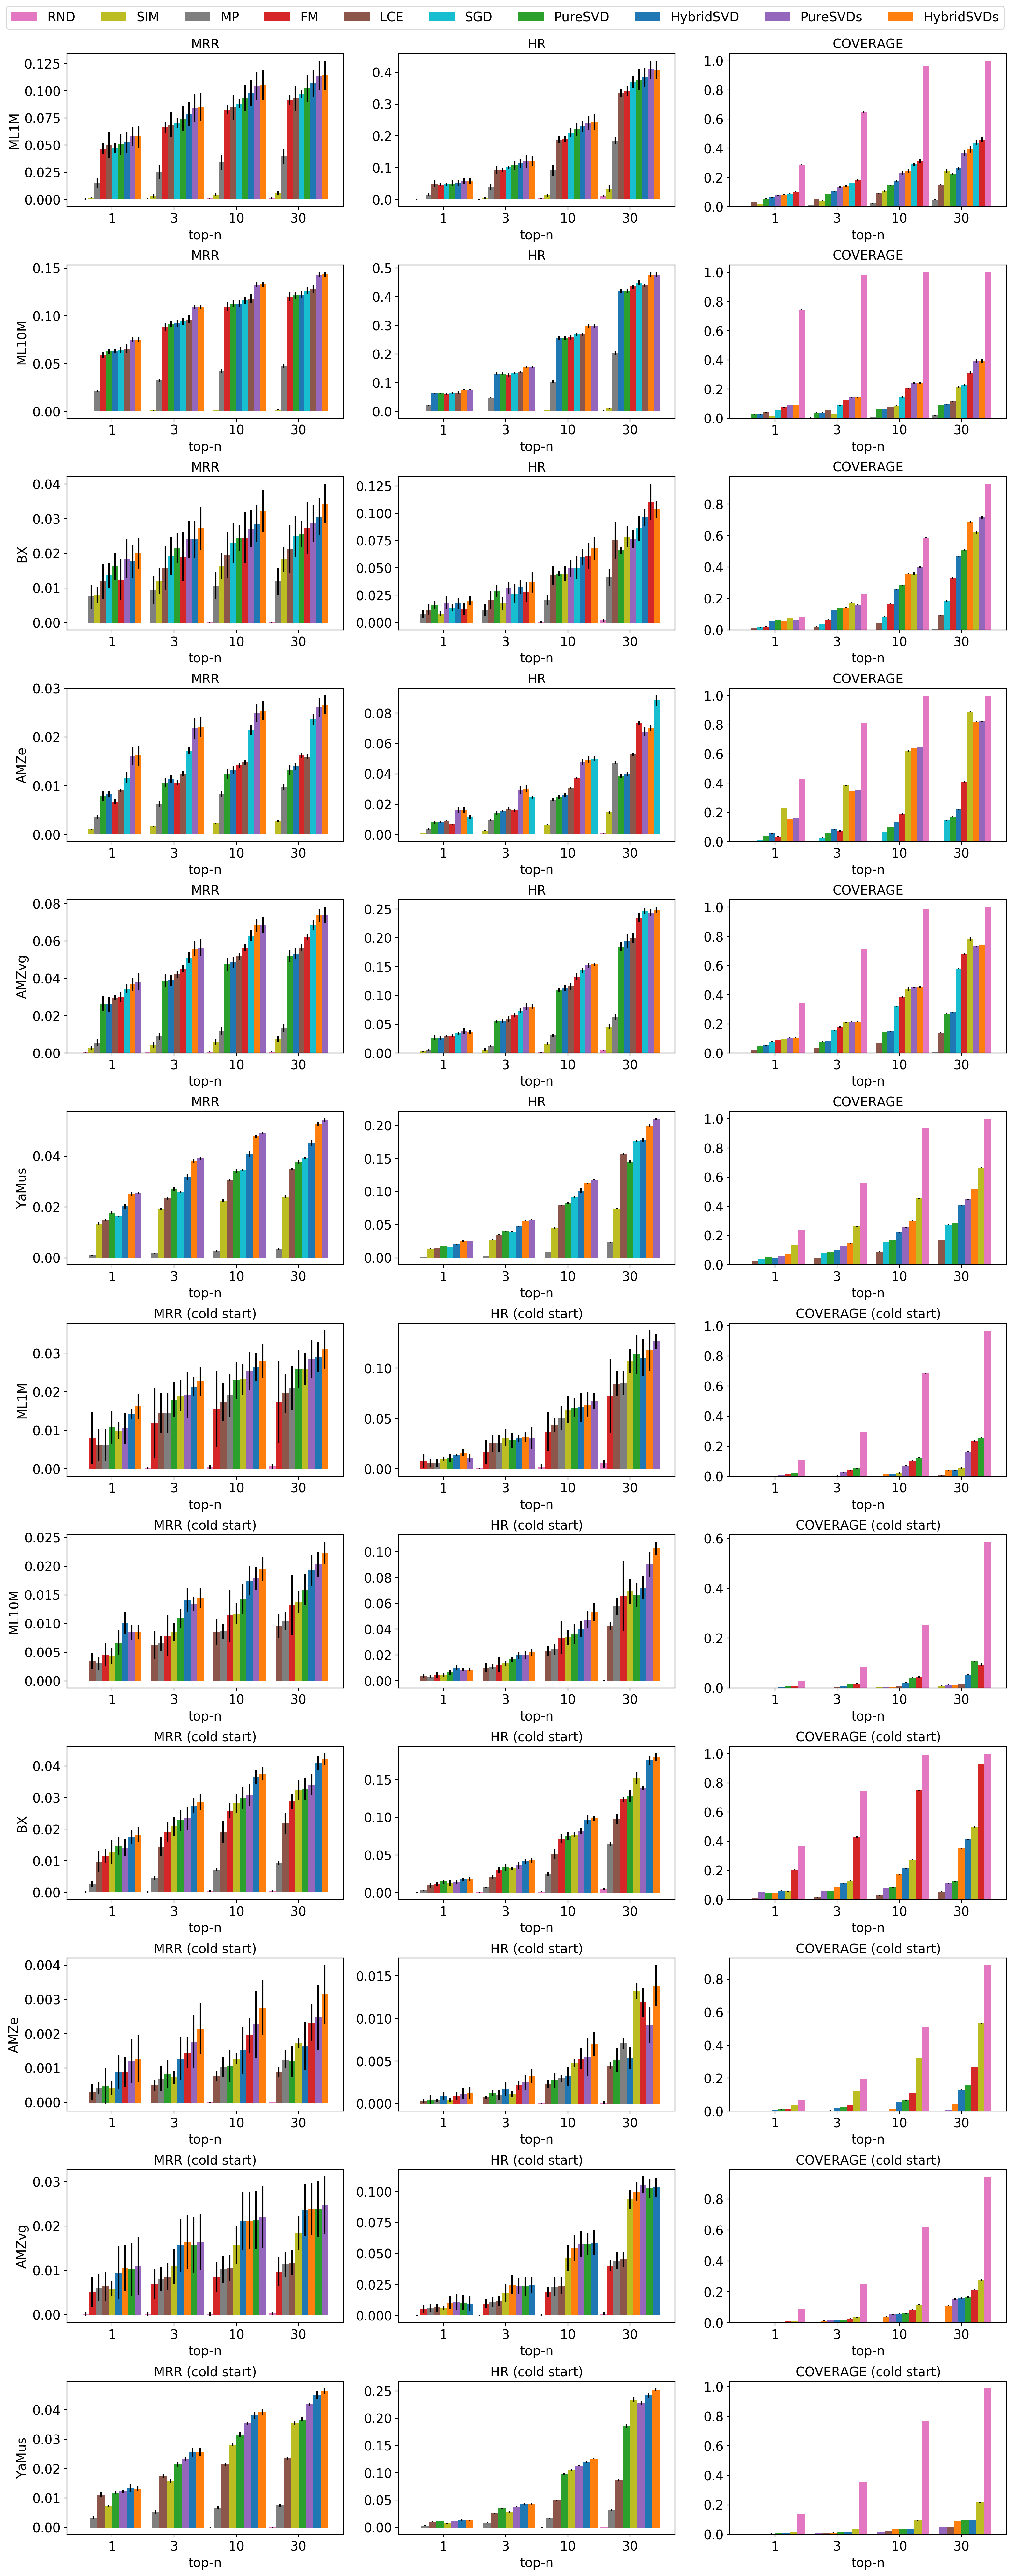

In [25]:
metrics = ['MRR', 'HR', 'COVERAGE']
fig, ax = plt.subplots(2*len(data_labels), len(metrics), figsize=(16, 40))

for i, lbl in enumerate(data_labels):
    for j, metric in enumerate(metrics):
        plot_topn_results([model[lbl] for model in all_standard if lbl in model],
                          metric, title=f'{metric}', ax=ax[i, j])
        plot_topn_results([model[lbl] for model in all_coldstart if lbl in model],
                          metric, title=f'{metric} (cold start)', ax=ax[i+6, j])

for i, lbl in enumerate(data_labels):
    ax[i, 0].set_ylabel(lbl)
    ax[i+6, 0].set_ylabel(lbl)
        
plt.tight_layout()
ax[0, 0].legend(bbox_to_anchor=(3.41, 1.35), loc='upper right', ncol=10)
# plt.savefig("all_experiments.pdf", bbox_inches='tight')

# Paper figures

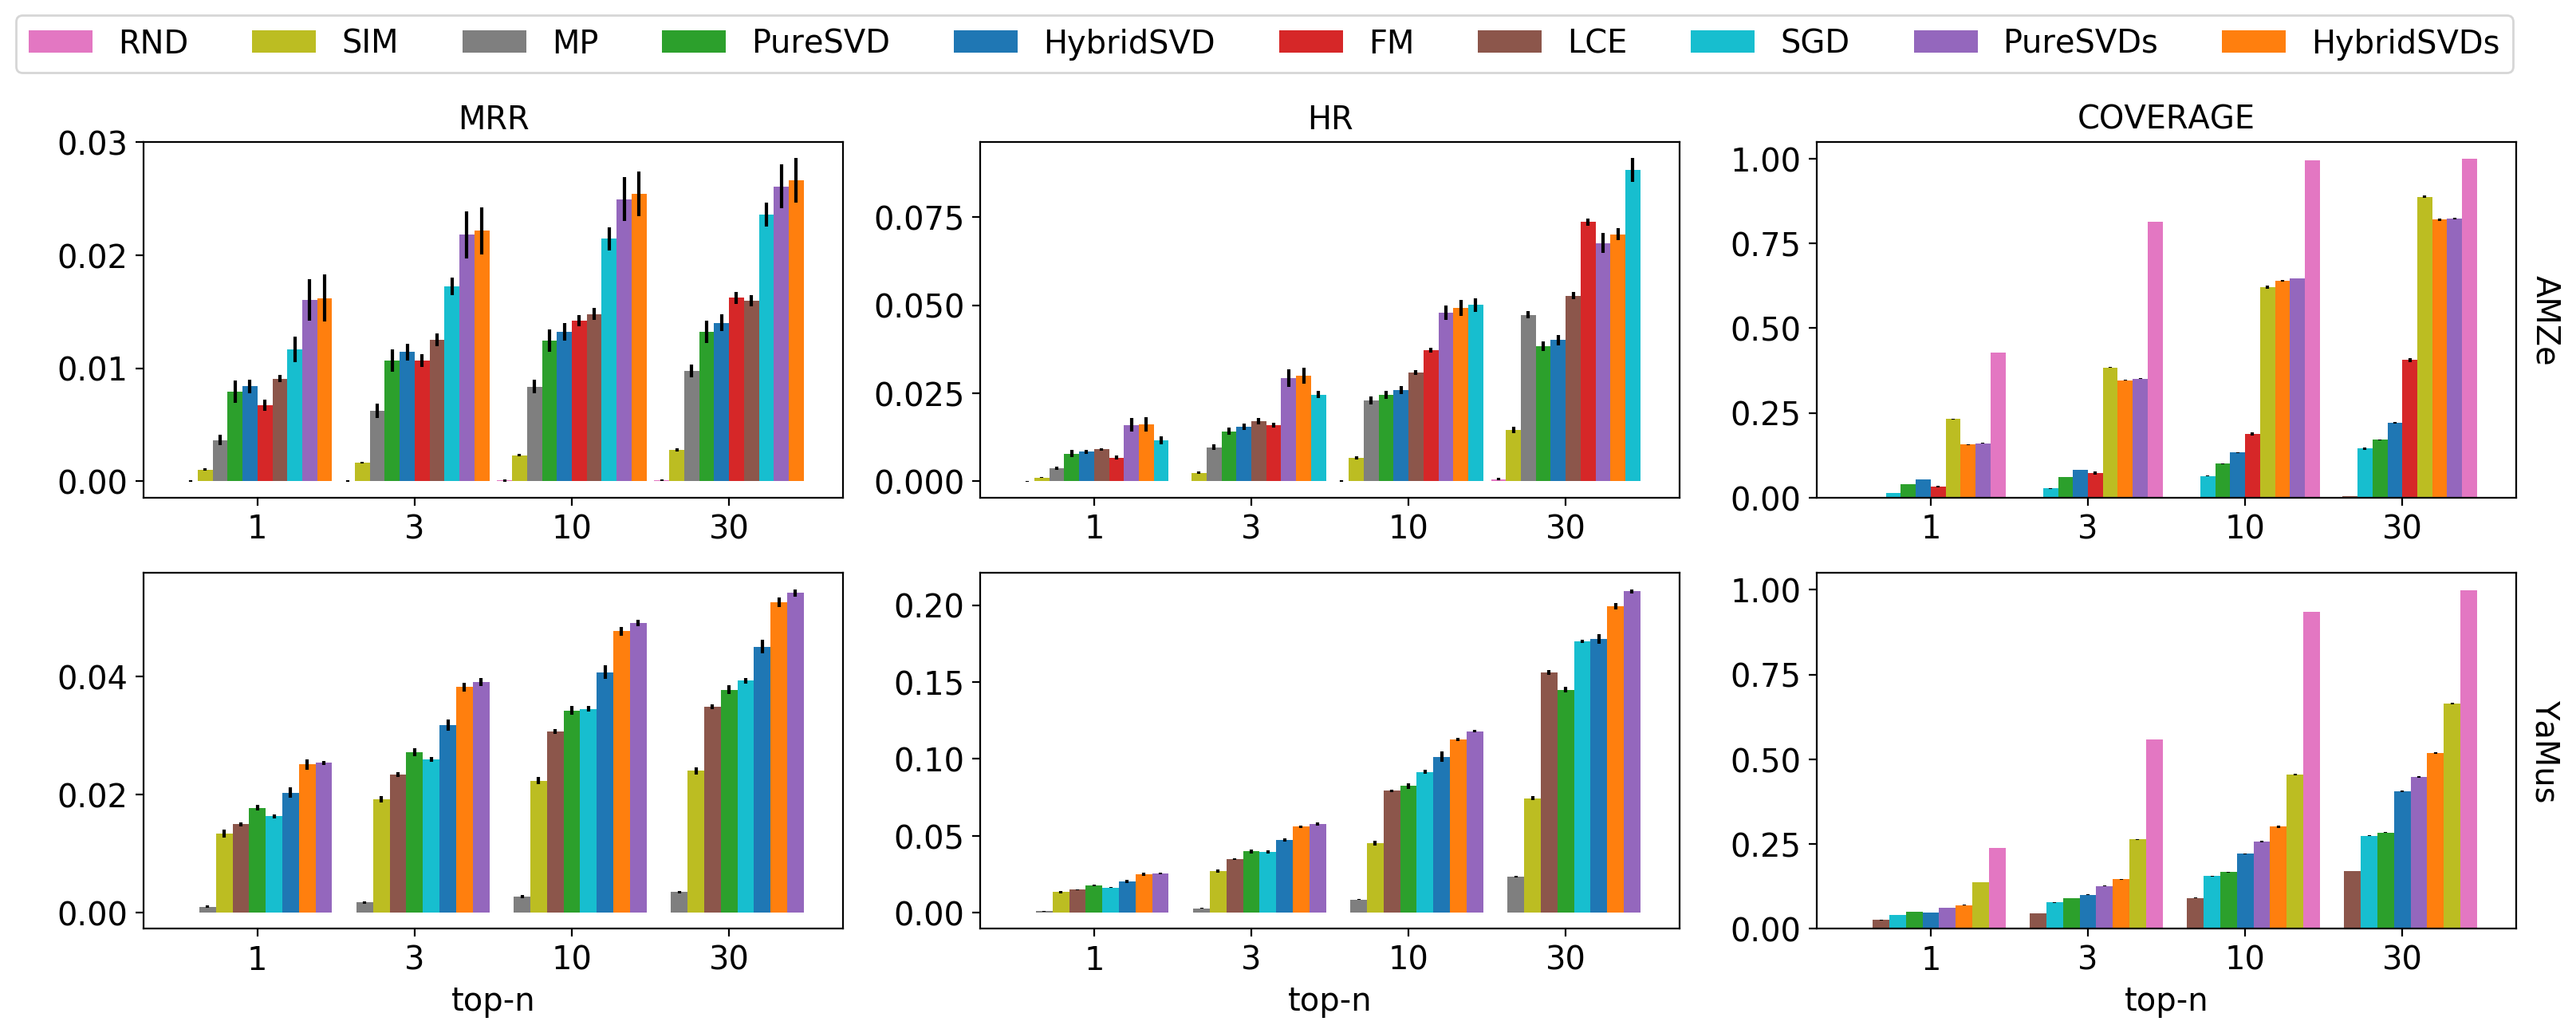

In [26]:
metrics = ['MRR', 'HR', 'COVERAGE']
data_labels_std = ['AMZe', 'YaMus']
fig, ax = plt.subplots(len(data_labels_std), len(metrics), figsize=(16, 6))

for i, lbl in enumerate(data_labels_std):
    for j, metric in enumerate(metrics):
        plot_topn_results([model[lbl] for model in all_standard if lbl in model],
                          metric, title=f'{metric}', ax=ax[i, j])

for i, lbl in enumerate(data_labels_std):
    ax[i, -1].set_ylabel(lbl, rotation=-90, labelpad=20)
    ax[i, -1].yaxis.set_label_position("right")
    if i != 0:
        for axi in ax[i, :]:
            axi.set_title('')    
    if i != len(data_labels_std)-1:
        for axi in ax[i, :]:
            axi.set_xlabel('')

plt.tight_layout()
ax[0, 0].legend(bbox_to_anchor=(3.41, 1.4), loc='upper right', ncol=10)
# plt.savefig("std_ML10_AMZe.pdf", bbox_inches='tight')

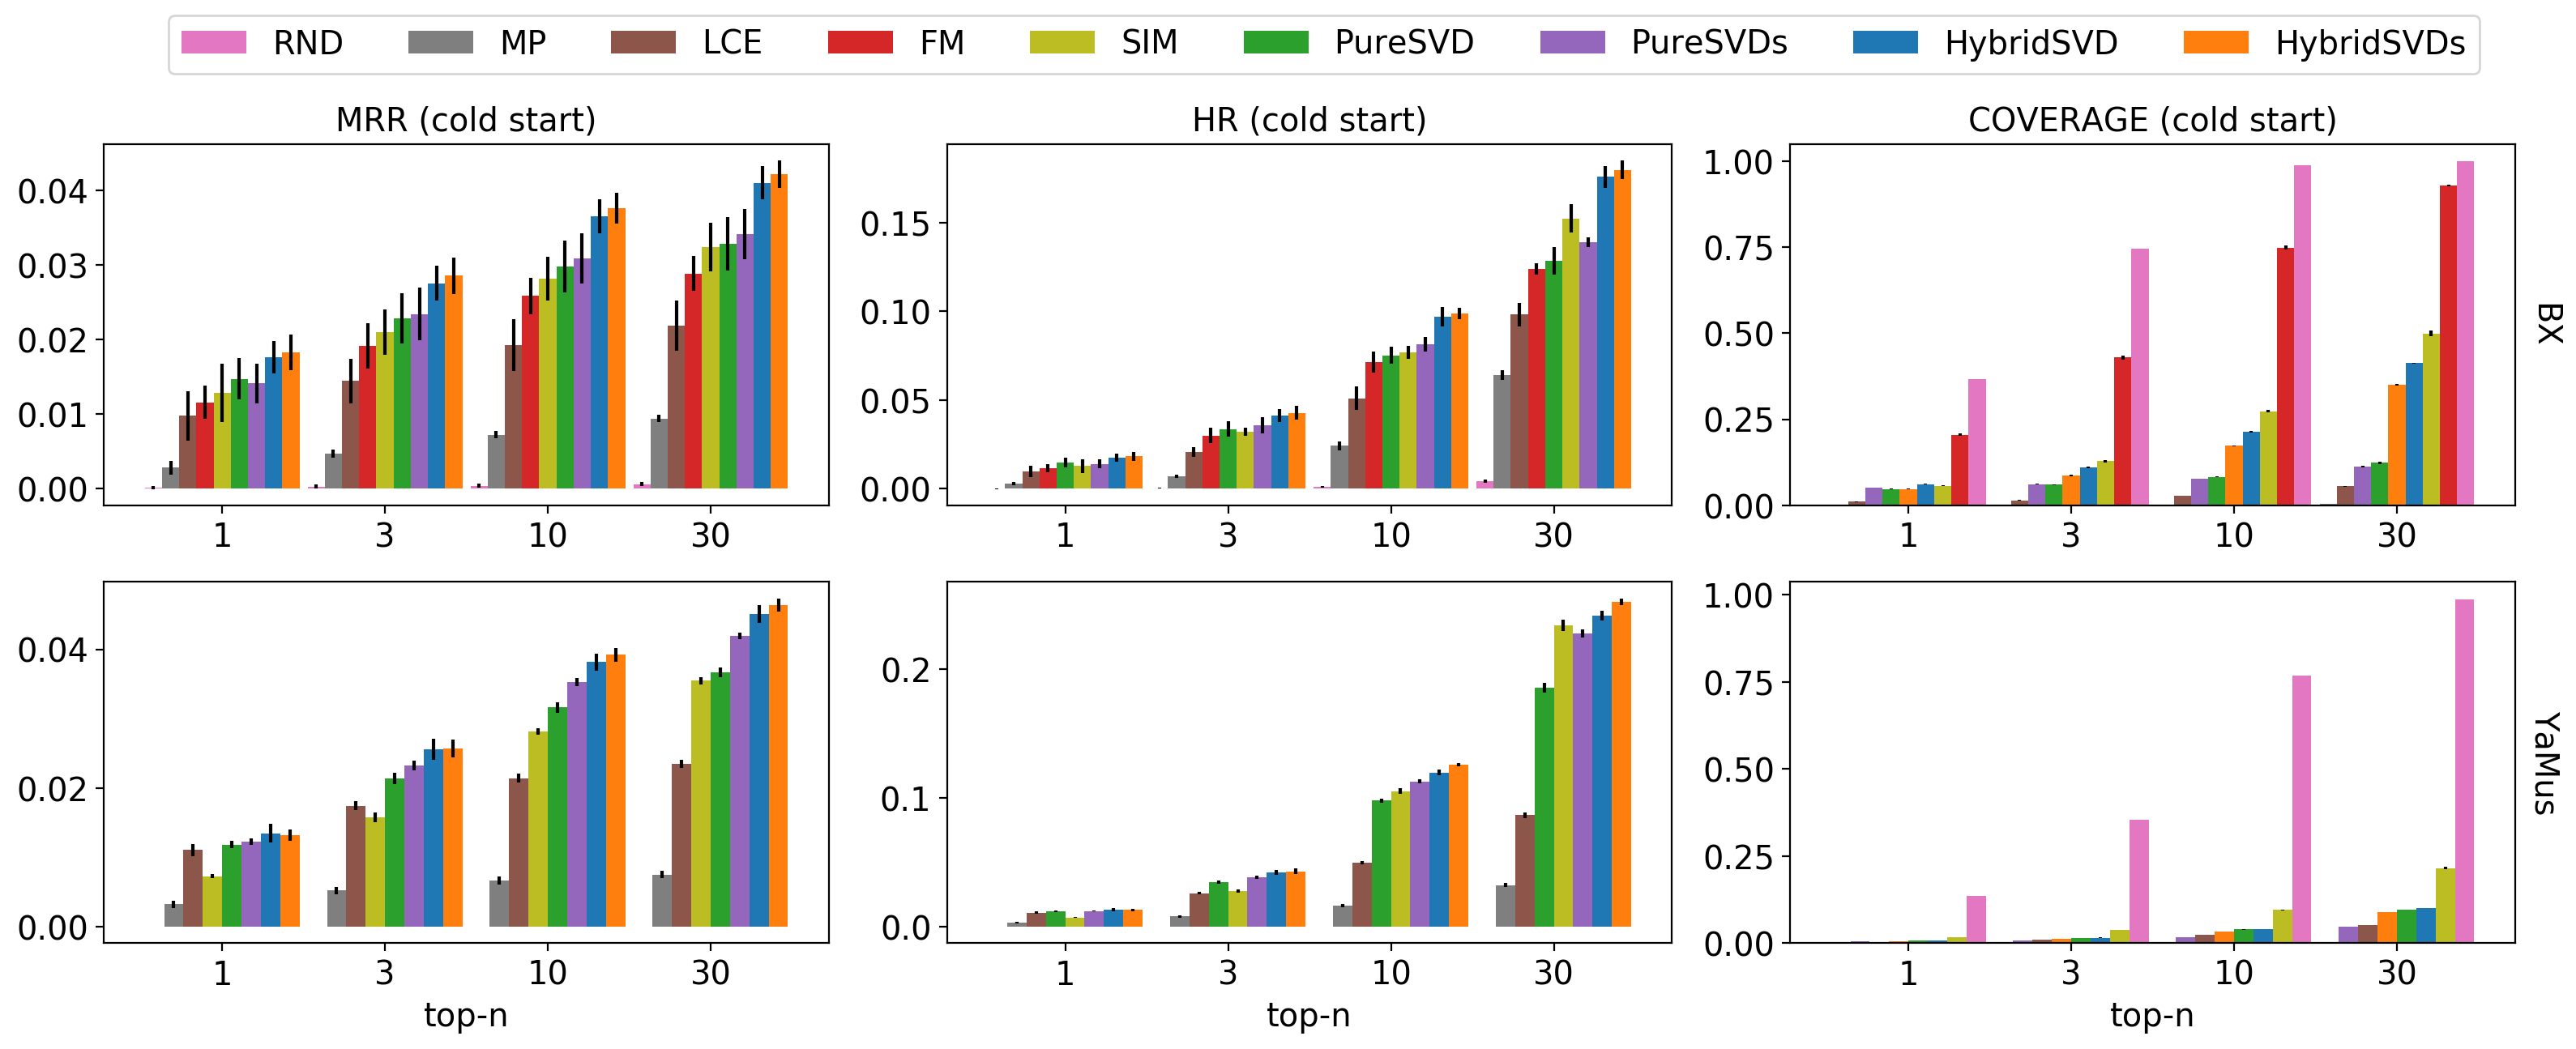

In [27]:
metrics = ['MRR', 'HR', 'COVERAGE']
data_labels_cls = ['BX', 'YaMus']
fig, ax = plt.subplots(len(data_labels_cls), len(metrics), figsize=(16, 6))

for i, lbl in enumerate(data_labels_cls):
    for j, metric in enumerate(metrics):
        plot_topn_results([model[lbl] for model in all_coldstart if lbl in model],
                          metric, title=f'{metric} (cold start)', ax=ax[i, j])

for i, lbl in enumerate(data_labels_cls):
    ax[i, -1].set_ylabel(lbl, rotation=-90, labelpad=20)
    ax[i, -1].yaxis.set_label_position("right")
    if i != 0:
        for axi in ax[i, :]:
            axi.set_title('')    
    if i != len(data_labels_cls)-1:
        for axi in ax[i, :]:
            axi.set_xlabel('')
        
plt.tight_layout()
ax[0, 0].legend(bbox_to_anchor=(3.3, 1.4), loc='upper right', ncol=10)
# plt.savefig("cls_BX_YM.pdf", bbox_inches='tight')

# Standard scenario

## Movielens-1M

In [29]:
lbl = 'ML1M'

In [30]:
models = [model[lbl] for model in all_standard]

In [ ]:
target_metric = 'MRR'
plot_topn_results(models, target_metric, title=f'{lbl}-{target_metric}')

In [ ]:
target_metric = 'HR'
plot_topn_results(models, target_metric, title=f'{lbl}-{target_metric}')

In [ ]:
target_metric = 'COVERAGE'
plot_topn_results(models, target_metric, title=f'{lbl}-{target_metric}')

## Movielens-10M

In [ ]:
lbl = 'ML10M'

In [ ]:
models = [model[lbl] for model in all_standard]

In [ ]:
target_metric = 'MRR'
plot_topn_results(models, target_metric, title=f'{lbl}-{target_metric}')

In [ ]:
target_metric = 'HR'
plot_topn_results(models, target_metric)

In [ ]:
target_metric = 'COVERAGE'
plot_topn_results(models, target_metric, title=f'{lbl}-{target_metric}')

## BookCrossing

In [ ]:
lbl = 'BX'

In [ ]:
models = [model[lbl] for model in all_standard]

In [ ]:
target_metric = 'MRR'
plot_topn_results(models, target_metric, title=f'{lbl}-{target_metric}')

In [ ]:
target_metric = 'HR'
plot_topn_results(models, target_metric, title=f'{lbl}-{target_metric}')

In [ ]:
target_metric = 'COVERAGE'
plot_topn_results(models, target_metric, title=f'{lbl}-{target_metric}')

## Amazon Electronics

In [ ]:
lbl = 'AMZe'

In [ ]:
models = [model[lbl] for model in all_standard]

In [ ]:
target_metric = 'MRR'
plot_topn_results(models, target_metric, title=f'{lbl}-{target_metric}')

In [ ]:
target_metric = 'HR'
plot_topn_results(models, target_metric, title=f'{lbl}-{target_metric}')

In [ ]:
target_metric = 'COVERAGE'
plot_topn_results(models, target_metric, title=f'{lbl}-{target_metric}')

## Amazon Video Games

In [ ]:
lbl = 'AMZvg'

In [ ]:
models = [model[lbl] for model in all_standard]

In [ ]:
target_metric = 'MRR'
plot_topn_results(models, target_metric, title=f'{lbl}-{target_metric}')

In [ ]:
target_metric = 'HR'
plot_topn_results(models, target_metric, title=f'{lbl}-{target_metric}')

In [ ]:
target_metric = 'COVERAGE'
plot_topn_results(models, target_metric, title=f'{lbl}-{target_metric}')

## Yahoo Music

In [ ]:
lbl = 'YaMus'

In [ ]:
target_metric = 'MRR'
plot_topn_results(models, target_metric, title=f'{lbl}-{target_metric}')

In [ ]:
target_metric = 'HR'
plot_topn_results(models, target_metric, title=f'{lbl}-{target_metric}')

In [ ]:
target_metric = 'COVERAGE'
plot_topn_results(models, target_metric, title=f'{lbl}-{target_metric}')

---

---

# Cold-start scenario

## Movielens-1M

In [ ]:
lbl = 'ML1M'

In [ ]:
models = [model[lbl] for model in all_coldstart]

In [ ]:
target_metric = 'MRR'
plot_topn_results(models, target_metric, title=f'{lbl}-{target_metric}(cs)')

In [ ]:
target_metric = 'HR'
plot_topn_results(models, target_metric, title=f'{lbl}-{target_metric}(cs)')

In [ ]:
target_metric = 'COVERAGE'
plot_topn_results(models, target_metric, title=f'{lbl}-{target_metric}(cs)')

## Movielens-10M

In [ ]:
lbl = 'ML10M'

In [ ]:
models = [model[lbl] for model in all_coldstart]

In [ ]:
target_metric = 'MRR'
plot_topn_results(models, target_metric, title=f'{lbl}-{target_metric}(cs)')

In [ ]:
target_metric = 'HR'
plot_topn_results(models, target_metric, title=f'{lbl}-{target_metric}(cs)')

In [ ]:
target_metric = 'COVERAGE'
plot_topn_results(models, target_metric, title=f'{lbl}-{target_metric}(cs)')

## BookCrossing

In [ ]:
lbl = 'BX'

In [ ]:
models = [model[lbl] for model in all_coldstart]

In [ ]:
target_metric = 'MRR'
plot_topn_results(models, target_metric, title=f'{lbl}-{target_metric}(cs)')

In [ ]:
target_metric = 'HR'
plot_topn_results(models, target_metric, title=f'{lbl}-{target_metric}(cs)')

In [ ]:
target_metric = 'COVERAGE'
plot_topn_results(models, target_metric, title=f'{lbl}-{target_metric}(cs)')

## Amazon Electronics

In [ ]:
lbl = 'AMZe'

In [ ]:
models = [model[lbl] for model in all_coldstart if lbl in model]

In [ ]:
target_metric = 'MRR'
plot_topn_results(models, target_metric, title=f'{lbl}-{target_metric}(cs)')

In [ ]:
target_metric = 'HR'
plot_topn_results(models, target_metric, title=f'{lbl}-{target_metric}(cs)')

In [ ]:
target_metric = 'COVERAGE'
plot_topn_results(models, target_metric, title=f'{lbl}-{target_metric}(cs)')

## Amazon Video Games

In [ ]:
lbl = 'AMZvg'

In [ ]:
models = [model[lbl] for model in all_coldstart if lbl in model]

In [ ]:
target_metric = 'MRR'
plot_topn_results(models, target_metric, title=f'{lbl}-{target_metric}(cs)')

In [ ]:
target_metric = 'HR'
plot_topn_results(models, target_metric, title=f'{lbl}-{target_metric}(cs)')

In [ ]:
target_metric = 'COVERAGE'
plot_topn_results(models, target_metric, title=f'{lbl}-{target_metric}(cs)')

## Yahoo Music

In [ ]:
lbl = 'YaMus'

In [ ]:
models = [model[lbl] for model in all_coldstart if lbl in model]

In [ ]:
target_metric = 'MRR'
plot_topn_results(models, target_metric, title=f'{lbl}-{target_metric}(cs)')

In [ ]:
target_metric = 'HR'
plot_topn_results(models, target_metric, title=f'{lbl}-{target_metric}(cs)')

In [ ]:
target_metric = 'COVERAGE'
plot_topn_results(models, target_metric, title=f'{lbl}-{target_metric}(cs)')

# Combined

## standard

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15, 4))

ax_std_mrr_ml = plot_rank_results([std_svd_ml, std_fm_ml], std_base_ml, ax=ax[0], metric='MRR', xlim=(0, 300), styles=line_styles)
ax_std_mrr_bx = plot_rank_results([std_svd_bx, std_fm_bx], std_base_bx, ax=ax[1], metric='MRR', xlim=(0, 3000), ylim=(-0.0009, 0.0175), styles=line_styles)

ax_std_mrr_ml.set_title('Movielens')
ax_std_mrr_bx.set_title('BookCrossing')
ax_std_mrr_ml.set_ylabel('MRR')


ax_std_mrr_bx.legend(loc=1, bbox_to_anchor=(1.6, 0.95))

# plt.tight_layout()
# plt.savefig("std_rank_mrr.pdf", bbox_inches='tight')

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15, 3.5))

ax_std_topn_mrr_ml = plot_topn_results(std_topn_ml.drop(r'HybridSVD ($\alpha=0.5$)', axis=1, level=0), metric='MRR', ax=ax[0], styles=line_styles, width=0.85, rot=0)
ax_std_topn_mrr_bx = plot_topn_results(std_topn_bx, metric='MRR', ax=ax[1], styles=line_styles, width=0.85, rot=0)

ax_std_topn_mrr_ml.set_title('Movielens')
ax_std_topn_mrr_ml.set_ylabel('MRR')
ax_std_topn_mrr_bx.set_title('BookCrossing')

axh1, axl1 = ax_std_topn_mrr_ml.get_legend_handles_labels()
axh2, axl2 = ax_std_topn_mrr_bx.get_legend_handles_labels()
axl = r'HybridSVD ($\alpha=0.5$)'
axh = axh2[axl2.index(axl)]

plt.legend(handles=axh1+[axh], labels=axl1+[axl], loc=1, bbox_to_anchor=(1.6, 0.95))
# plt.savefig("std_topn_mrr.pdf", bbox_inches='tight')

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 2, figsize=(17, 8))

ax_std_mrr_ml = plot_rank_results([std_svd_ml, std_fm_ml], std_base_ml, ax=ax1[0], metric='MRR', xlim=(1, 1000), logx=True, ylim=(None, 0.115), styles=line_styles)
ax_std_mrr_bx = plot_rank_results([std_svd_bx, std_fm_bx], std_base_bx, ax=ax1[1], metric='MRR', xlim=(1, 3000), logx=True, ylim=(-0.0009, 0.0185), styles=line_styles)

ax_std_mrr_ml.set_title('Movielens')
ax_std_mrr_bx.set_title('BookCrossing')
ax_std_mrr_ml.set_ylabel('MRR@10')


ax_std_mrr_bx.legend(loc=2, bbox_to_anchor=(-0.85, 0.98))


ax_std_topn_mrr_ml = plot_topn_results(std_topn_ml.drop(r'HybridSVD ($\alpha=0.5$)', axis=1, level=0), metric='MRR', ax=ax2[0], styles=line_styles, width=0.85, rot=0, ylim=(0, None))
ax_std_topn_mrr_bx = plot_topn_results(std_topn_bx, metric='MRR', ax=ax2[1], styles=line_styles, ylim=(0, None), width=0.85, rot=0)

ax_std_topn_mrr_ml.set_ylabel('MRR@$n$')
ax_std_topn_mrr_ml.set_xlabel('top-$n$')
ax_std_topn_mrr_bx.set_xlabel('top-$n$')

axh1, axl1 = ax_std_topn_mrr_ml.get_legend_handles_labels()
axh2, axl2 = ax_std_topn_mrr_bx.get_legend_handles_labels()
axl = r'HybridSVD ($\alpha=0.5$)'
axh = axh2[axl2.index(axl)]

plt.legend(handles=reversed(axh1+[axh]), labels=reversed(axl1+[axl]), loc=2, bbox_to_anchor=(-0.85, 0.93))
fig.subplots_adjust(wspace=0.9, hspace=0.28)

# plt.savefig("std_mrr.pdf", bbox_inches='tight')

## cold-start

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15, 4))

ax_cls_mrr_ml = plot_rank_results([cls_svd_ml, cls_fm_ml], cls_base_ml, metric='MRR', ax=ax[0], xlim=(1, 1000), logx=True, styles=line_styles)
ax_cls_mrr_bx = plot_rank_results([cls_svd_bx, cls_fm_bx], cls_base_bx, metric='MRR', ax=ax[1], xlim=(1, 3000), logx=True, styles=line_styles)

ax_cls_mrr_ml.set_title('Movielens')
ax_cls_mrr_bx.set_title('BookCrossing')
ax_cls_mrr_ml.set_ylabel('MRR')


ax_cls_mrr_bx.legend(loc=1, bbox_to_anchor=(1.6, 0.95))
# plt.tight_layout()
# plt.savefig("cls_rank_mrr.pdf", bbox_inches='tight')

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15, 3.5))

ax_cls_topn_mrr_ml = plot_topn_results(cls_topn_ml.drop(r'HybridSVD ($\alpha=0.5$)', axis=1, level=0), metric='MRR', ax=ax[0], styles=line_styles, width=0.85, rot=0)
ax_cls_topn_mrr_bx = plot_topn_results(cls_topn_bx.drop(r'HybridSVD ($\alpha=0.5$)', axis=1, level=0), metric='MRR', ax=ax[1], styles=line_styles, width=0.85, rot=0)

ax_cls_topn_mrr_ml.set_title('Movielens')
ax_cls_topn_mrr_ml.set_ylabel('MRR')
ax_cls_topn_mrr_bx.set_title('BookCrossing')

ax_cls_topn_mrr_bx.legend(bbox_to_anchor=(1.6, 0.95))
# plt.savefig("cls_topn_mrr.pdf", bbox_inches='tight')

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 2, figsize=(17, 8))


ax_cls_mrr_ml = plot_rank_results([cls_svd_ml, cls_fm_ml], cls_base_ml, metric='MRR', ax=ax1[0], xlim=(1, 1000), ylim=(-0.001, 0.033), logx=True, styles=line_styles)
ax_cls_mrr_bx = plot_rank_results([cls_svd_bx, cls_fm_bx], cls_base_bx, metric='MRR', ax=ax1[1], xlim=(1, 3200), ylim=(-0.001, 0.047), logx=True, styles=line_styles)

ax_cls_mrr_ml.set_title('Movielens')
ax_cls_mrr_bx.set_title('BookCrossing')
ax_cls_mrr_ml.set_ylabel('MRR@10')

ax_cls_mrr_bx.legend(loc=2, bbox_to_anchor=(-0.85, 0.98))

ax_cls_topn_mrr_ml = plot_topn_results(cls_topn_ml.drop(r'HybridSVD ($\alpha=0.5$)', axis=1, level=0), metric='MRR', ax=ax2[0], styles=line_styles, ylim=(0, None), width=0.85, rot=0)
ax_cls_topn_mrr_bx = plot_topn_results(cls_topn_bx.drop(r'HybridSVD ($\alpha=0.5$)', axis=1, level=0), metric='MRR', ax=ax2[1], styles=line_styles, width=0.85, rot=0, ylim=(-0.0001, None))

ax_cls_topn_mrr_ml.set_ylabel('MRR@$n$')
ax_cls_topn_mrr_ml.set_xlabel('top-$n$')
ax_cls_topn_mrr_bx.set_xlabel('top-$n$')

handles, labels = ax_cls_topn_mrr_bx.get_legend_handles_labels()
ax_cls_topn_mrr_bx.legend(reversed(handles), reversed(labels), loc=2, bbox_to_anchor=(-0.85, 0.85))

fig.subplots_adjust(wspace=0.9, hspace=0.28)

plt.savefig("cls_mrr.pdf", bbox_inches='tight')